In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import shutil
import tempfile

2024-05-18 19:11:53.230573: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-18 19:11:53.230673: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-18 19:11:53.362948: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
dataset_path = '/kaggle/input/stage-2-classification/Stage 2 Classification'

In [3]:
temp_dir = tempfile.mkdtemp()

class_names = os.listdir(dataset_path)

os.makedirs(temp_dir + '/train')
os.makedirs(temp_dir + '/val')
os.makedirs(temp_dir + '/test')

for class_name in class_names:
    os.makedirs(temp_dir + '/train/' + class_name)
    os.makedirs(temp_dir + '/val/' + class_name)
    os.makedirs(temp_dir + '/test/' + class_name)
    
    image_names = os.listdir(dataset_path + '/' + class_name)
    np.random.shuffle(image_names)
    
    train_names = image_names[:int(len(image_names)*0.7)]
    val_names = image_names[int(len(image_names)*0.7):int(len(image_names)*0.85)]
    test_names = image_names[int(len(image_names)*0.85):]

    for name in train_names:
        shutil.copy(dataset_path + '/' + class_name + '/' + name, temp_dir + '/train/' + class_name + '/' + name)
    for name in val_names:
        shutil.copy(dataset_path + '/' + class_name + '/' + name, temp_dir + '/val/' + class_name + '/' + name)
    for name in test_names:
        shutil.copy(dataset_path + '/' + class_name + '/' + name, temp_dir + '/test/' + class_name + '/' + name)

datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    temp_dir + '/train',
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary')

validation_generator = datagen.flow_from_directory(
    temp_dir + '/val',
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary')

test_generator = datagen.flow_from_directory(
    temp_dir + '/test',
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary')

Found 1854 images belonging to 2 classes.
Found 397 images belonging to 2 classes.
Found 398 images belonging to 2 classes.


In [4]:
base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss=losses.BinaryCrossentropy(),
              optimizer=optimizers.Adam(learning_rate=0.00001),
              metrics=['accuracy'])

19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [5]:
checkpoint = ModelCheckpoint('best_weights.weights.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1, save_weights_only=True)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, restore_best_weights=True)

history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[checkpoint, earlystop]
)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1716060526.600313     125 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  1/116 ━━━━━━━━━━━━━━━━━━━━ 8:43:20 273s/step - accuracy: 0.2500 - loss: 1.8394

W0000 00:00:1716060526.883898     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4800 - loss: 1.0394

W0000 00:00:1716060704.346221     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_loss improved from inf to 0.68067, saving model to best_weights.weights.h5
116/116 ━━━━━━━━━━━━━━━━━━━━ 466s 2s/step - accuracy: 0.4803 - loss: 1.0384 - val_accuracy: 0.5441 - val_loss: 0.6807
Epoch 2/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.5821 - loss: 0.7661
Epoch 2: val_loss did not improve from 0.68067
116/116 ━━━━━━━━━━━━━━━━━━━━ 20s 165ms/step - accuracy: 0.5821 - loss: 0.7660 - val_accuracy: 0.5416 - val_loss: 0.6863
Epoch 3/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.6032 - loss: 0.7077
Epoch 3: val_loss did not improve from 0.68067
116/116 ━━━━━━━━━━━━━━━━━━━━ 21s 177ms/step - accuracy: 0.6033 - loss: 0.7077 - val_accuracy: 0.5642 - val_loss: 0.6830
Epoch 4/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.6474 - loss: 0.6526
Epoch 4: val_loss improved from 0.68067 to 0.67431, saving model to best_weights.weights.h5
116/116 ━━━━━━━━━━━━━━━━━━━━ 23s 193ms/step - accuracy: 0.6475 - loss: 0.6526 - val_accuracy: 0.5793 - 

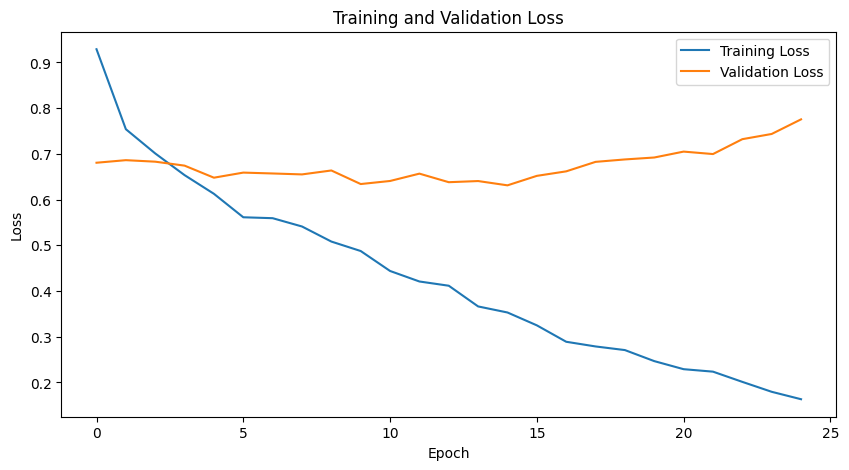

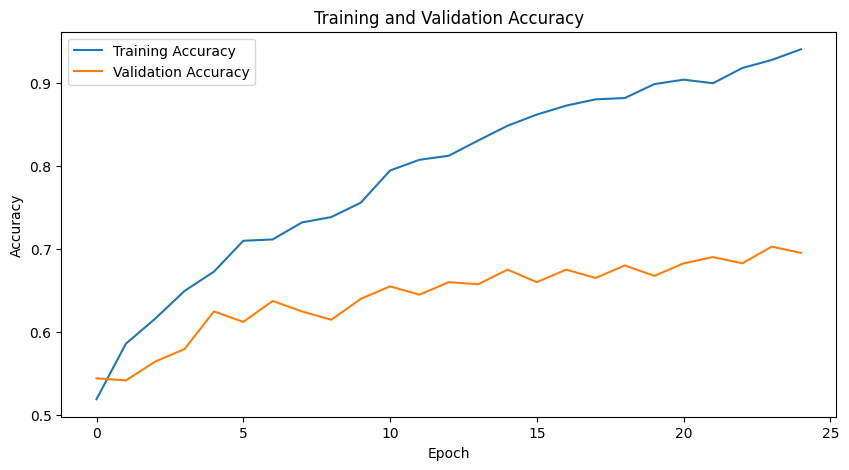

In [7]:

# Extracting the loss and accuracy history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plotting the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In [8]:
model.load_weights('best_weights.weights.h5')

test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 409ms/step - accuracy: 0.6750 - loss: 0.5702
Test Loss: 0.5897, Test Accuracy: 0.67%
